## Projet BIP :
### Objectifs :

L'objectif de ce projet est de développer une méthode de localisation des noeuds d'arbre dans une image en déterminant leurs caractéristiques, telles que la taille et l'excentricité.

In [122]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.color import rgb2gray,label2rgb
from skimage.filters import sobel,threshold_otsu,threshold_li,median,gaussian,prewitt,threshold_local
from scipy.ndimage import label as lb
from skimage.measure import regionprops,label,regionprops_table
import skimage.morphology as morpho
import numpy as np
import os
import matplotlib.patches as mpatches
from skimage import img_as_float,io, color, img_as_float
from scipy.signal import fftconvolve
from skimage.transform import resize


In [123]:
def read_images_from_folder(folder_path):
    """
    Cette fonction lit les images à partir d'un dossier et les convertit en niveaux de gris.
    
    Args:
    - folder_path (str): Le chemin du dossier contenant les images.
    
    Returns:
    - images (list): Une liste d'images converties en niveaux de gris.
    """
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg')):  
            img_path = os.path.join(folder_path, filename)
            img = io.imread(img_path)
            img=rgb2gray(img)
            img=img_as_float(img)  
            if img is not None:
                images.append(img)  # Add the image to the list
    return images


In [124]:
folder_path = './Image_data'
image_dataset = read_images_from_folder(folder_path)

## Optimisation de la Détection des Noeuds : Approche par Disjonction de cas
Pour la détection des noeuds, il est apparu évident que l'obtention d'une précision élevée pour les gros noeuds et les petits noeuds simultanément s'avère difficile. Cela résulte de la disparité des filtres appliqués (érosion, ouverture, etc.) sur les images, car dans le cas des petits noeuds, une érosion pourrait induire une perte manifeste d'informations utiles, pouvant même entraîner la non-détection de certains noeuds.

Afin de pallier ce problème de perte d'information et d'optimiser le taux de détection des noeuds, nous avons adopté une approche par cas disjoint. Dans un premier temps, nous évaluons le type de noeud prédominant dans l'image. Ensuite, nous appliquons la méthode de détection des gros noeuds ou celle des petits noeuds en conséquence, permettant ainsi une meilleure adaptation à la diversité des caractéristiques des noeuds présents.

In [3]:
def thresholding_big_knots(image):
    """
    Cette fonction applique une méthode de seuillage pour détecter les gros noeuds d'arbre dans une image.
    
    Args:
    - image (array): L'image d'entrée.
    
    Returns:
    - filtered_regions (list): Une liste de régions (noeuds) filtrées selon leur taille et excentricité.
    """
    min_area = 10000
    max_area = 900000

    threshold_max = (image).max()
    threshold = threshold_max * 0.4

    # Filtre Gaussien
    img_gauss = gaussian(image, sigma=1)

    # Seuillage de l'image
    mask = img_gauss < threshold

    # Application de masques
    fh_mask = binary_fill_holes(mask)
    d_mask = morpho.binary_dilation(fh_mask, footprint=morpho.disk(3))
    e_mask = morpho.binary_erosion(d_mask)

    # Labelisation des régions
    label_image = label(e_mask)
    regions = regionprops(label_image)
    filtered_regions = []
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('Image avec bounding box sur les noeuds détectés')
    ax.imshow(image, 'gray')
    centroid = None
    for region in regionprops(label_image):
        if min_area < region.area < max_area and 0 <= region.eccentricity < 0.9:
             minr, minc, maxr, maxc = region.bbox
             
             rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
             ax.add_patch(rect)
             centroid = region.centroid
             ax.plot(centroid[1], centroid[0], 'ro', markersize=5)

    if centroid is None: #Si on ne detecte pas de gros noeuds on applique les seuils de détection des petits noeuds
        for region in regionprops(label_image):
            if region.area > 5 and 0 <= region.eccentricity < 0.9:
                minr, minc, maxr, maxc = region.bbox
                
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                centroid = region.centroid
                ax.plot(centroid[1], centroid[0], 'ro', markersize=5) 
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    fig = plt.figure()
    plt.title('Plot des regions détectées ')
    plt.imshow(label_image)
    plt.show()
    return filtered_regions

### Paramétrage de cette détection

Pour notre méthode, on fait une disjonction de cas a partir de l'aire de la region détectée avec une certaine excentricité.

La fonction thresholding_big_knots vise à détecter les gros nœuds d'arbre dans une image en utilisant une méthode de seuillage.

**min_area** et **max_area:** Ces paramètres définissent la taille minimale et maximale d'une région (noeud) à conserver. Les régions dont la taille est en dehors de cette plage seront exclues. On assume qu'une aire au delà de 10000 pixels est bien adaptée pour détecter les gros noeuds de bois(Observation à partir de plusieurs itération sur le dataset fournit).

L'image originale est lissée à l'aide d'un filtre gaussien avec un écart-type de 1. Cela nous a aidé à reduire le bruit dans l'image.

**Le seuillage** est effectué en comparant les valeurs de luminosité lissées avec le seuil calculé. Les pixels en dessous du seuil sont considérés comme noirs, tandis que ceux au-dessus sont considérés comme blancs. Cela permet de mettre en évidence les disparités de couleur entre le bois et les nœuds, qui souvent présentent des teintes différentes.

**Les masques appliqués:**

- Les trous sont comblés dans les régions blanches à l'aide de la fonction binary_fill_holes.

- Une opération de dilatation est effectuée sur le masque résultant avec un élément structurant en forme de disque de rayon 3. On a remarqué qu'une dilation sous forme de disque (omnidirectionnelle) est moins discriminatoire que celle avec la forme de base 'plus' (+) nous permet de reconstruire mieux les regions.

- Ensuite, une érosion est appliquée au masque dilaté, pour enlever toutes les petites particules qui peuvent provenir du bruit.

    L'objectif global des masques est de créer des régions cohérentes, dépourvues de bruit, sur lesquelles l'algorithme de détection peut être appliqué de manière robuste. 

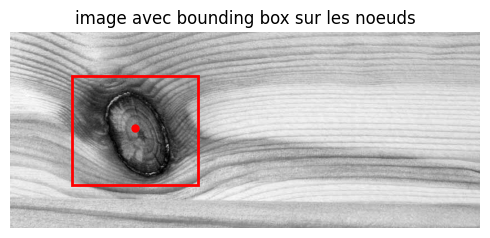

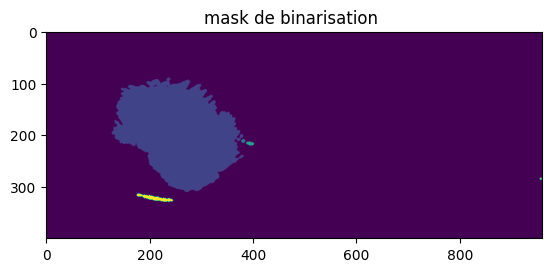

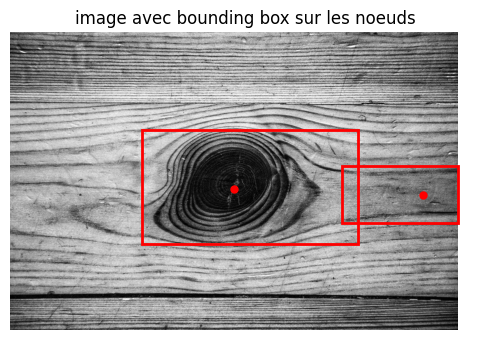

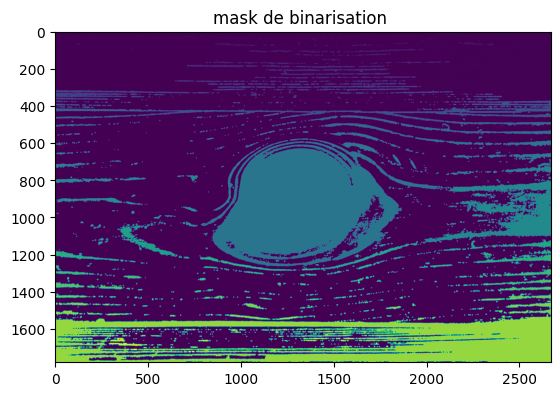

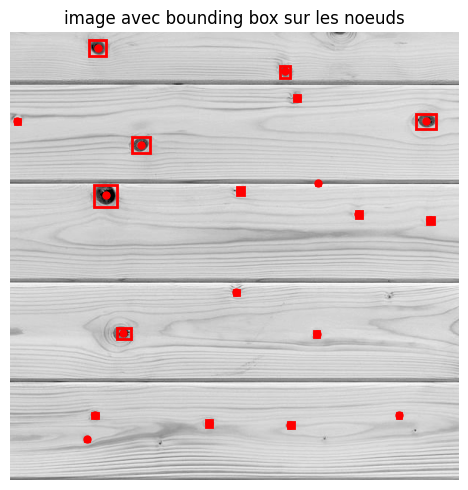

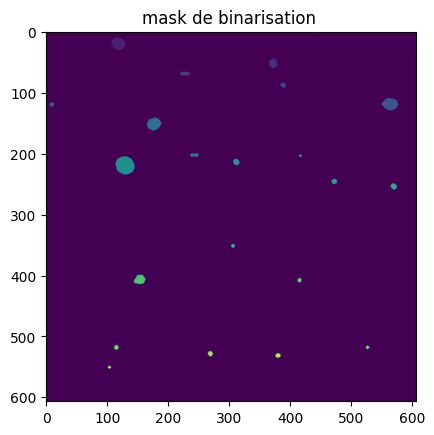

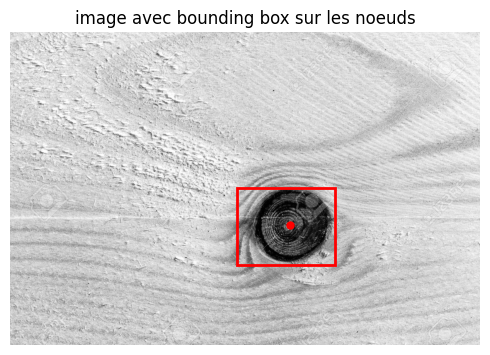

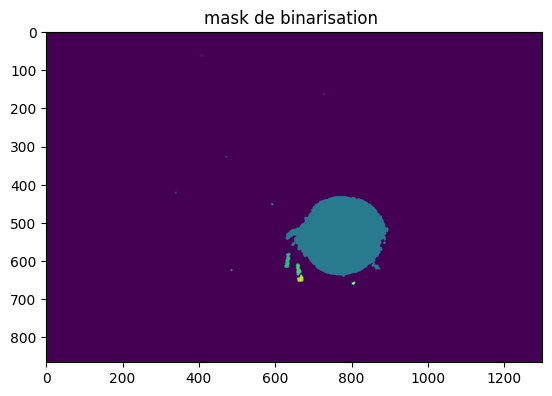

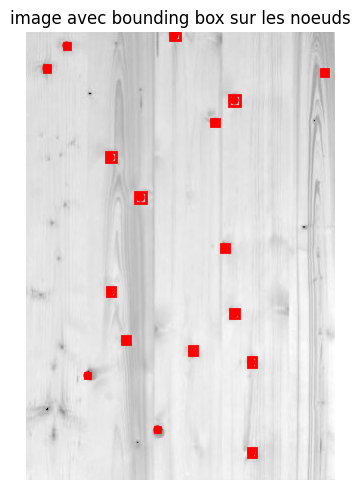

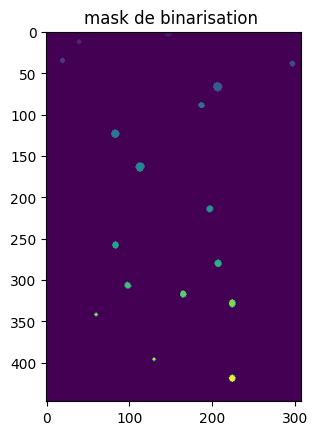

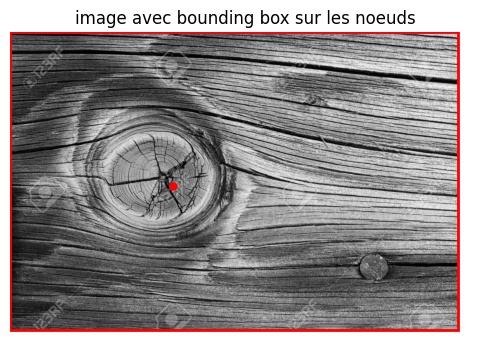

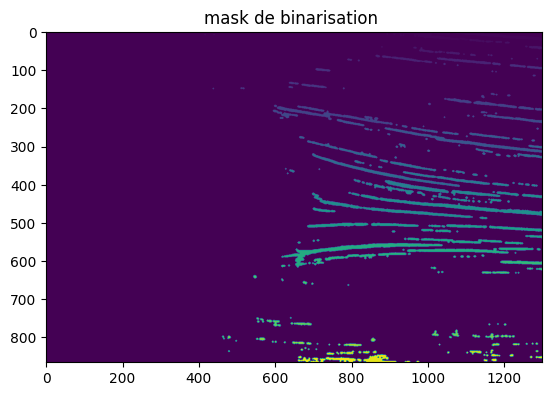

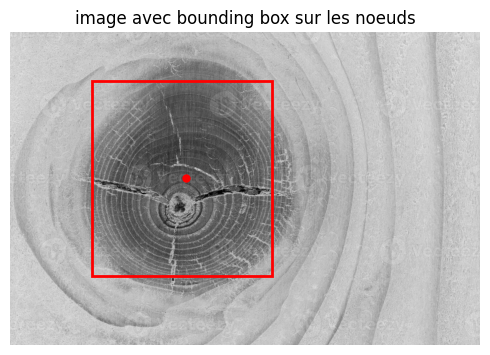

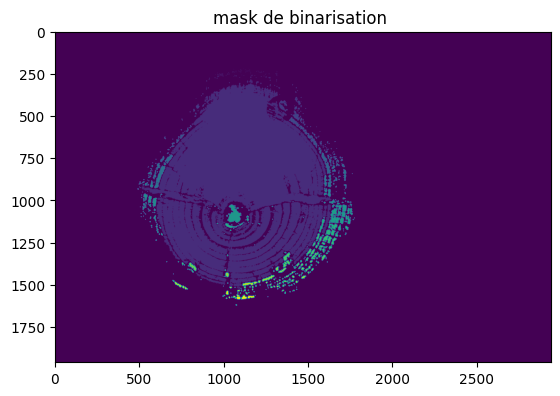

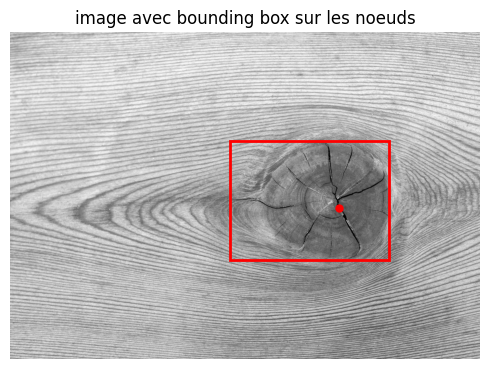

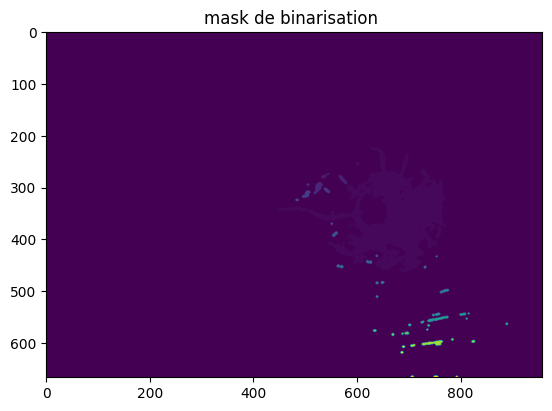

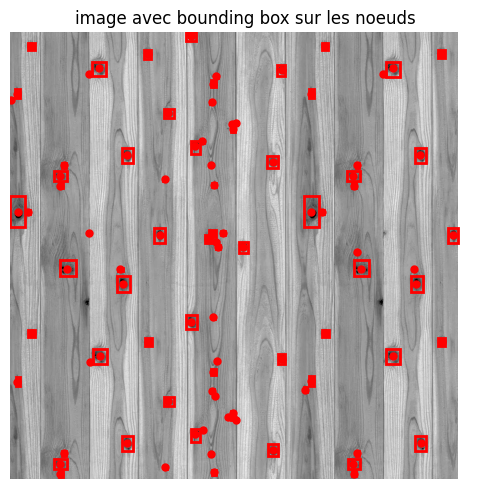

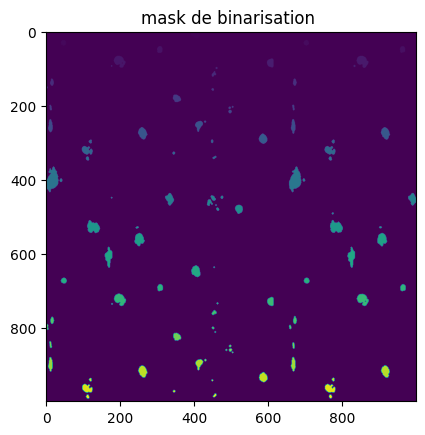

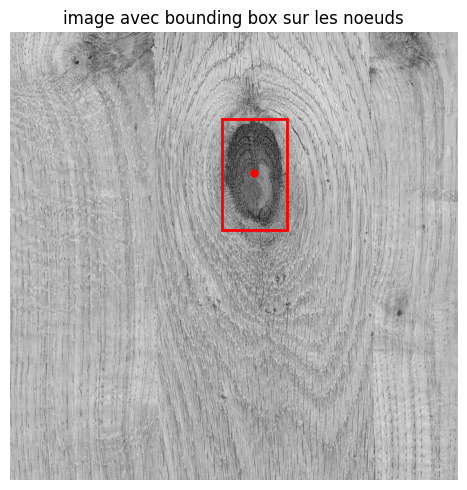

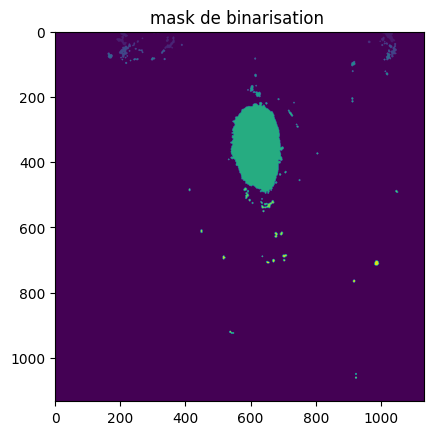

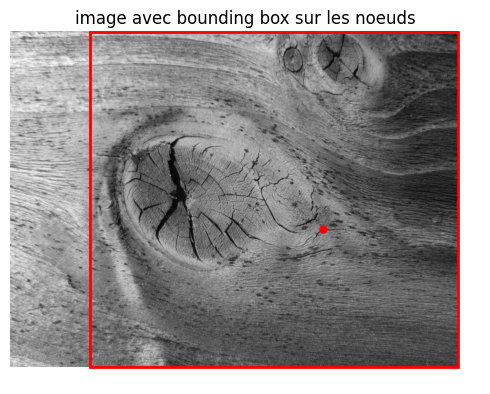

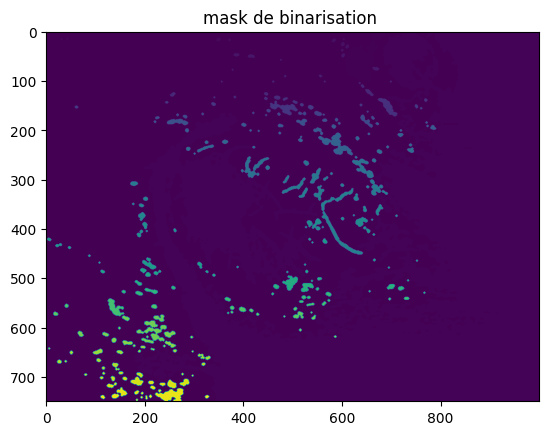

In [201]:
List_properties=[]
for i in range(len(image_dataset)):
    filtered_regionpts=thresholding_big_knots(image_dataset[i])
    List_properties.append(filtered_regionpts)

### Analyse des résultats

L'analyse des résultats de la détection des nœuds révèle une performance globalement satisfaisante. La méthode mise en œuvre par le code parvient à détecter la grande majorité des nœuds présents dans les images traitées. Cependant, une inspection plus approfondie des résultats révèle la présence de quelques faux positifs et faux négatifs.

En ce qui concerne les faux positifs, il s'agit probablement de régions de l'image qui sont erronément identifiées comme des nœuds. Ces erreurs peuvent être attribuées à la sensibilité du seuillage ou à la présence d'éléments dans l'image susceptibles de confondre le détecteur.

D'autre part, les faux négatifs indiquent des cas où des nœuds réels ne sont pas détectés par l'algorithme. Ces erreurs peuvent résulter de divers facteurs tels que des variations locales de contraste, des déformations des nœuds ou des irrégularités dans l'éclairage.

### Analyse critique :

**Méthode de seuillage :** Dans le cadre de la méthode de seuillage adoptée, il convient de noter que cette approche, bien que simple, peut présenter des limites significatives en cas de variations importantes de l'éclairage et du contraste. Les images 3 et 8 fournissent des exemples concrets illustrant ces contraintes. Pour optimiser la détection, il serait judicieux d'explorer des stratégies de seuillage adaptatif ou des techniques prenant en compte les variations locales dans l'image.

**Approche non généralisée :** La méthode que nous avons élaborée suppose que l'image ne contient que des nœuds de petite taille ou de grande taille. Ainsi, si l'image présente une combinaison des deux types de nœuds, l'algorithme risque de ne détecter que les nœuds de grande taille. Pour remédier à cela, une approche consiste d'abord à appliquer la détection des nœuds de grande taille, puis la détection des nœuds de petite taille. Si les deux fonctions détectent des nœuds, cela signifie que la coexistence des deux types de nœuds est présente dans la même image. Dans ce cas, il est nécessaire de traiter cette situation de manière distincte, éventuellement en appliquant une méthode de détection locale jusqu'à ce qu'un seul type de nœuds soit obtenu dans une sous-image.

## Optimisation de la Détection des Noeuds : Approche en utilisant HoughCircles opencv

In [121]:
def Hough_knots_detection(img):
    min_area = 10000
    max_area = 900000

    threshold_max = (img).max()
    threshold = threshold_max * 0.4

    # Filtre Gaussien
    img_gauss = gaussian(img, sigma=1)

    # Seuillage de l'image
    mask = img_gauss < threshold

    # Application de masques
    fh_mask = binary_fill_holes(mask)
    d_mask = morpho.binary_dilation(fh_mask, footprint=morpho.disk(3))
    e_mask = morpho.binary_erosion(d_mask)

    # Labelisation des régions
    label_image = label(e_mask)

    # Apply GaussianBlur to reduce noise and help the edge detection
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Sobel operators to get gradients in the x and y directions
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude of the gradients
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the magnitude to be in the range [0, 1]
    gradient_magnitude_normalized = gradient_magnitude / np.max(gradient_magnitude)

    # Apply Canny edge detection
    edges_canny = cv2.Canny((gradient_magnitude_normalized * 255).astype(np.uint8), 180, 450)
    cimg = cv2.cvtColor(edges_canny,cv2.COLOR_GRAY2BGR)
    centroid = None
    for region in regionprops(label_image):
        if min_area < region.area < max_area and 0 <= region.eccentricity < 0.9:
             centroid = region.centroid

    if centroid is None: #Si on ne detecte pas de gros noeuds on applique les seuils de détection des petits noeuds
        circles = cv2.HoughCircles(
            edges_canny,
            cv2.HOUGH_GRADIENT,
            dp=1,  # Inverse ratio of the accumulator resolution to the image resolution
            minDist=23,  # Minimum distance between the centers of the detected circles
            param2=10,  # Threshold for center detection
            minRadius=1,  # Minimum radius to be detected
            maxRadius=20  # Maximum radius to be detected
        )
    else:
        circles = cv2.HoughCircles(
                edges_canny,
                cv2.HOUGH_GRADIENT,
                dp=1,  # Inverse ratio of the accumulator resolution to the image resolution
                minDist=178*2,  # Minimum distance between the centers of the detected circles
                param2=10,  # Threshold for center detection
                minRadius=178,  # Minimum radius to be detected
                maxRadius=200  # Maximum radius to be detected
            )
                
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
    plt.imshow(cimg)
    plt.show()
    
    return circles

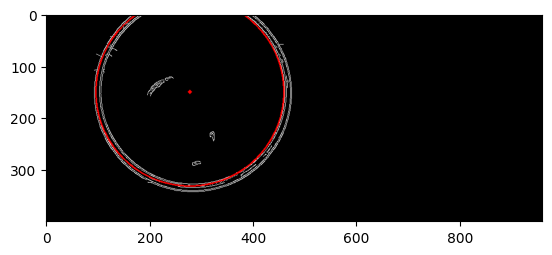

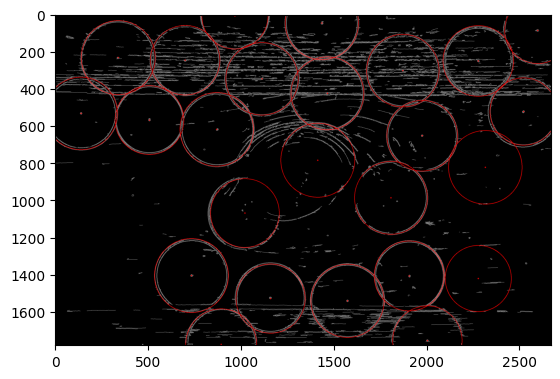

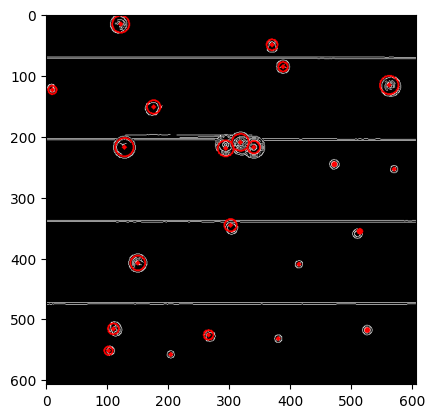

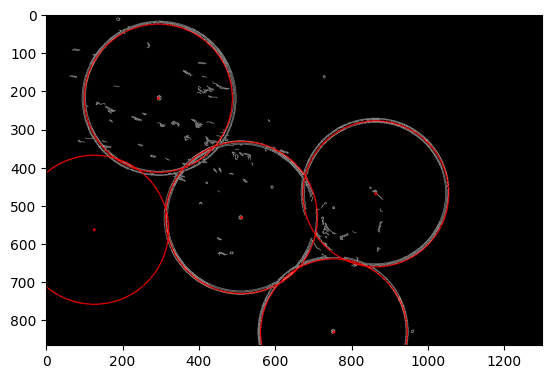

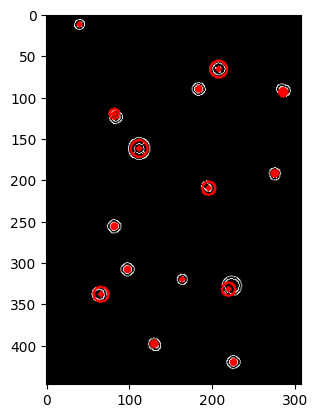

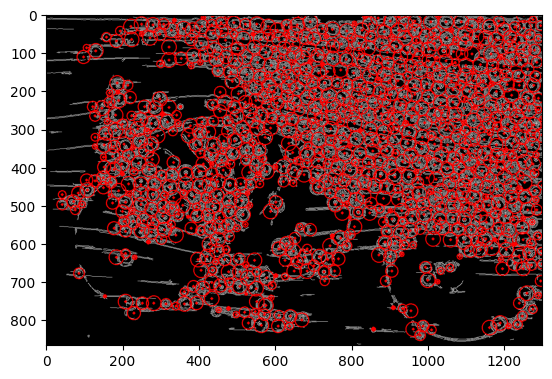

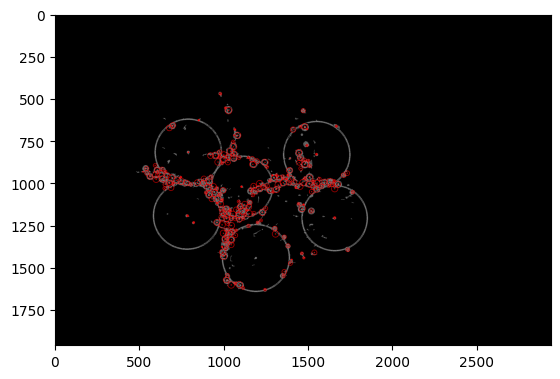

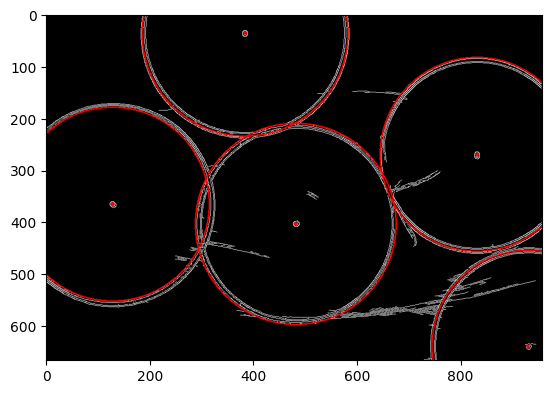

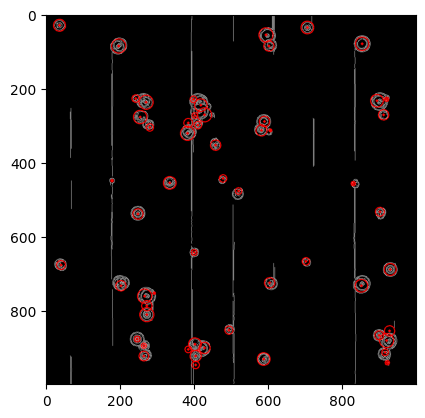

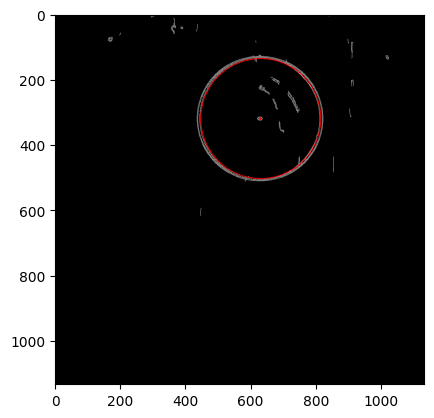

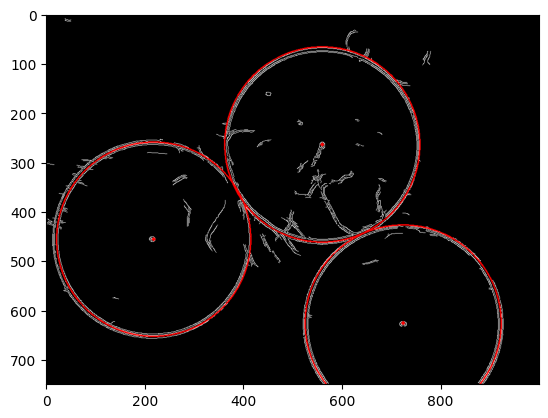

In [120]:
for i in range(len(image_dataset)):
    Hough_knots_detection(image_dataset[i])

### Analyse des résultats

La méthode basée sur les cercles de Hough démontre une efficacité remarquable dans la détection des petits nœuds, parvenant même à identifier tous les petits nœuds, ce qui représente une amélioration significative par rapport à la méthode précédente. Cependant, des défis subsistent lorsqu'il s'agit de détecter les grands nœuds. Cette difficulté provient principalement de la déformation plus prononcée des grands nœuds, associée à une plus grande complexité de détails environnants. Ces caractéristiques ont probablement influencé nos résultats lors de l'application de la transformée de Hough pour les cercles, entraînant des performances moins concluantes dans ce contexte particulier.

### Analyse critique
**Approche non généralisée :** Tout comme l'approche précédente, cette méthode n'est pas généralisée pour le cas où les deux types de nœuds sont présents.

## Comparaison avec les méthodes d'état d'art

Les méthodes qu'on a utilisées sont très limitées et ne peuvent pas être comparées aux méthodes modernes qui se basent sur des modèles CNN. Ces modèles sont très robustes aux divers paramètres qui peuvent influencer la détection d'objets dans une image.

1. **Capacité d'apprentissage :** Les CNN peuvent apprendre des motifs complexes et des caractéristiques discriminantes directement à partir des données, ce qui les rend plus adaptables à différentes conditions.

2. **Généralisation :** Les méthodes basées sur CNN peuvent généraliser leur apprentissage à des images qui n'ont pas été vues pendant l'entraînement, contrairement aux méthodes traditionnelles qui peuvent être plus spécifiques à certaines conditions.

3. **Détection simultanée de différents types de nœuds :** Les CNN peuvent être formés pour détecter différents types d'objets simultanément, ce qui résoudrait le problème mentionné dans l'approche par disjonction de cas.

4. **Adaptabilité aux variations de taille et de forme :** Les méthodes basées sur CNN sont souvent plus adaptées aux variations de taille et de forme des objets, ce qui peut être un défi avec des approches traditionnelles.

5. **Évolutivité :** Les modèles CNN peuvent être élargis pour traiter des ensembles de données plus vastes et plus diversifiés, tandis que les méthodes traditionnelles peuvent nécessiter des ajustements manuels importants.

## Conclusion

Le projet a débuté par l'objectif de développer une méthode de localisation des nœuds d'arbre dans une image, en se concentrant sur des caractéristiques telles que la taille et l'excentricité. Deux approches ont été explorées pour la détection des nœuds : une première méthode basée sur le seuillage et une deuxième méthode utilisant la transformée de Hough pour détecter des cercles.

La première approche, basée sur le seuillage, a montré des résultats limités en raison de la sensibilité aux variations d'éclairage et de contraste. De plus, elle n'était pas généralisée pour détecter simultanément des gros et petits nœuds.

La deuxième approche, basée sur la transformée de Hough pour les cercles, a montré une efficacité notable dans la détection des petits nœuds, mais a rencontré des défis lors de la détection des gros nœuds en raison de leurs déformations plus complexes.

Pour une amélioration significative de la détection des nœuds, il faut considérer des méthodes plus modernes, telles que l'utilisation de réseaux de neurones convolutionnels (CNN), étant donné que, les méthodes classiques ne peuvent pas être robuste dans toutes les situations.

La continuité logique de ce projet pourrait donc consister à explorer et mettre en œuvre des architectures de CNN pour la détection des nœuds.